In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import mne
import mne_features
import entropy as ent
import neurokit2 as nk
from scipy.signal import welch
from nolds import lyap_r
import antropy as ant
import joblib

In [67]:
participantsInfo = pd.read_table('./ds004504/participants.tsv')
#Getting all the groups
A_sub = participantsInfo[participantsInfo["Group"] == "A"]["participant_id"].tolist()
C_sub = participantsInfo[participantsInfo["Group"] == "C"]["participant_id"].tolist()
D_sub = participantsInfo[participantsInfo["Group"] == "F"]["participant_id"].tolist()

In [68]:
freq_bands = {
    "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alpha": (8, 12),
    "Beta": (12, 30),
}

import pandas as pd
import numpy as np 

#this generates the dataframe persubject
def generate_subject_dataframe(subjects) -> pd.DataFrame:
    """
    Generates a DataFrame where each subject has 19 channels, 
    and each channel has 4 bands (Delta, Theta, Alpha, Beta).
    
    Parameters:
        num_subjects (int): Number of subjects to include in the DataFrame.
    
    Returns:
        pd.DataFrame: A DataFrame with hierarchical indexing for subjects, channels, and bands for each window.
    """
    # subjects = [f"sub-{i:03d}" for i in range(start_sub, end_sub + 1)]  # Format subject IDs as sub-XXX
    channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
    bands = ["Delta", "Theta", "Alpha", "Beta"]
    
    data = []
    for subject in subjects:
        for channel in channels:
            for band, val in freq_bands.items():
                value = np.random.rand()  # Example random value, replace with actual data if needed
                data.append([subject, channel, band, []])
    
    df = pd.DataFrame(data, columns=["Subject", "Channel", "Band", "Window Avg"])

    #the .setIndex is creating a multiIndex DataFrame
    return df.set_index(["Subject", "Channel", "Band"])


    # Example usage:
# df = generate_subject_dataframe(5)  # Generates a DataFrame for 5 subjects
# print(df)

In [69]:
def derivativesPath(sub): #dericatives is the preprocessed data
    return f"ds004504/{sub}/eeg/{sub}_task-eyesclosed_eeg.set"



# NUM_SUBJECTS = 2
# # Use the function inside the groups dictionary
# groups = {
#     'Alzeimers': generate_subject_dataframe(A_sub[0:NUM_SUBJECTS]),
#     'Control': generate_subject_dataframe(C_sub[0:NUM_SUBJECTS]),
#     'Dementia': generate_subject_dataframe(D_sub[0:NUM_SUBJECTS]),
# }

# NUM_SUBJECTS = 2
# # Use the function inside the groups dictionary
groups = {
    'Alzeimers': generate_subject_dataframe(A_sub),
    'Control': generate_subject_dataframe(C_sub),
    'Dementia': generate_subject_dataframe(D_sub),
}

# Print the DataFrame for 'Alzeimers'

# WINDOW_LENGTH = 1.5
# STEP_SIZE = .75 #50% sliding window
WINDOW_LENGTH = 3
STEP_SIZE = 1.5

In [70]:
print(A_sub[0:NUM_SUBJECTS])

NameError: name 'NUM_SUBJECTS' is not defined

In [43]:
print(groups['Alzeimers'])
print(groups['Control'])
print(groups['Dementia'])

                      Window Avg
Subject Channel Band            
sub-001 Fp1     Delta         []
                Theta         []
                Alpha         []
                Beta          []
        Fp2     Delta         []
...                          ...
sub-036 Cz      Beta          []
        Pz      Delta         []
                Theta         []
                Alpha         []
                Beta          []

[2736 rows x 1 columns]
                      Window Avg
Subject Channel Band            
sub-037 Fp1     Delta         []
                Theta         []
                Alpha         []
                Beta          []
        Fp2     Delta         []
...                          ...
sub-065 Cz      Beta          []
        Pz      Delta         []
                Theta         []
                Alpha         []
                Beta          []

[2204 rows x 1 columns]
                      Window Avg
Subject Channel Band            
sub-066 Fp1     Delta     

# Testing to see if we are calculating the mean correctly

Not setting metadata
398 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 398 events and 1501 original time points ...
0 bad epochs dropped
Min 0.5, Max 30
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
freqs[0.66622252 0.99933378 1.33244504 1.6655563  1.99866755 2.33177881
 2.66489007 2.99800133 3.33111259 3.66422385 3.99733511]
channel at that freq [[[1.95509618e-06 1.26024497e-06 1.29766764e-06 7.94023914e-07
   3.59715680e-07 2.15450412e-07 9.95105394e-08 8.49783908e-08
   4.46531141e-08 3.09587555e-08 2.56653026e-08]]]
5.607240819161222e-07
Plotting power spectral density (dB=True).
Need more than one channel to make topography for eeg. Disabling interactivity.


/Users/admin/neuro-venv/lib/python3.9/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


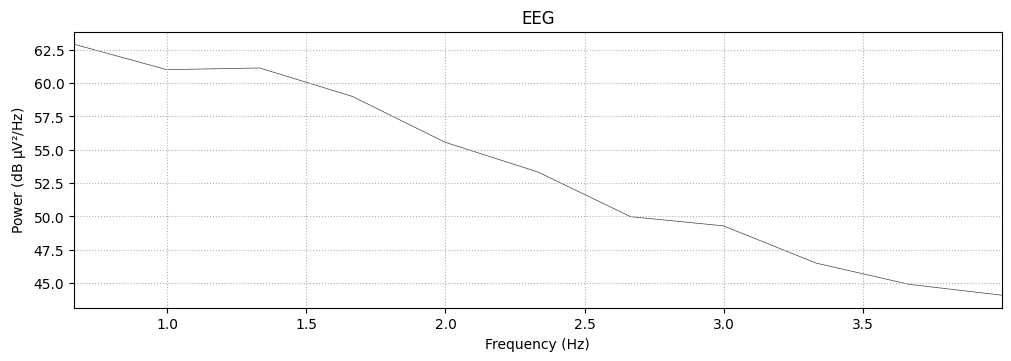

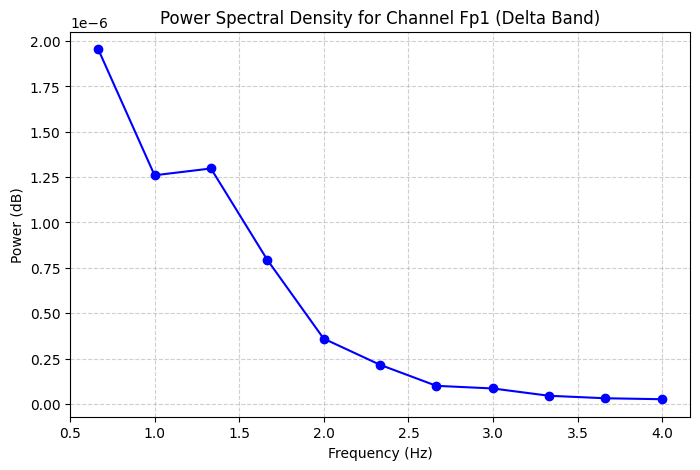

In [63]:
#print(groups['Control'].loc[('sub-037', 'Fp1', 'Delta'), "Window Avg"][0])
raw_sub = mne.io.read_raw_eeglab(derivativesPath('sub-001'), preload=True)
sfreq = raw_sub.info['sfreq']
start_times = np.arange(0, raw_sub.times[-1] - WINDOW_LENGTH, STEP_SIZE) 
events = np.array([
[int(t * sfreq), 0, 1] for t in start_times  # MNE event format
]) 

epochs = mne.Epochs(
    raw_sub, events, event_id=1,
    tmin=0, tmax=WINDOW_LENGTH,
    baseline=None, detrend=1, preload=True, verbose=True
)
epoch = epochs[0]
print(f'Min {freq_bands["Delta"][0]}, Max {freq_bands["Beta"][1]}')
epoch_psd = epoch.compute_psd(fmin=freq_bands["Delta"][0], fmax=freq_bands["Beta"][1], verbose=True) #computing the max PSD between the wave lengths
epoch_psd = epoch.compute_psd(fmin=0.5, fmax=4, verbose=True) #computing the max PSD between the wave lengths
channel_at_freq, freqs = epoch_psd.get_data(picks='Fp1' , fmin=freq_bands["Delta"][0], fmax=freq_bands["Delta"][1], return_freqs=True)

mean_power = channel_at_freq.mean(axis=0)
channel_at_freq_avg = channel_at_freq.mean(axis=-1)
print(f'freqs{freqs}')
print(f'channel at that freq {channel_at_freq}')
print(channel_at_freq_avg[0][0])
#5.607240819161222e-07

epoch_psd.plot(picks='Fp1')


# Plot Power Spectral Density (PSD)
plt.figure(figsize=(8, 5))
plt.plot(freqs, channel_at_freq[0][0], color="blue", marker='o', linestyle='-')

# Labels and title
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (dB)")
plt.title("Power Spectral Density for Channel Fp1 (Delta Band)")
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

from mne.time_frequency import psd_welch
# specific frequency bands
# FREQ_BANDS = {"delta": [0.5, 4.5],
#                   "theta": [4.5, 8.5],
#                   "alpha": [8.5, 11.5],
#                   "sigma": [11.5, 15.5],
#                   "beta": [15.5, 30]}
 
# psds, freqs = psd_welch(epochs, picks='eeg', fmin=0.5, fmax=30.)

 # Normalize the PSDs
psds /= np.sum(psds, axis=-1, keepdims=True)

X = []
for fmin, fmax in FREQ_BANDS.values():
    psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
    X.append(psds_band.reshape(len(psds), -1))


In [103]:
# from mne.time_frequency import psd_welch
#print(groups['Control'].loc[('sub-037', 'Fp1', 'Delta'), "Window Avg"][0])

raw_sub = mne.io.read_raw_eeglab(derivativesPath('sub-001'), preload=True)
sfreq = raw_sub.info['sfreq']
start_times = np.arange(0, raw_sub.times[-1] - WINDOW_LENGTH, STEP_SIZE) 
events = np.array([
[int(t * sfreq), 0, 1] for t in start_times  # MNE event format
]) 

epochs = mne.Epochs(
    raw_sub, events, event_id=1,
    tmin=0, tmax=WINDOW_LENGTH,
    baseline=None, detrend=1, preload=True, verbose=True
)
epoch = epochs[0]
print(f'Min {freq_bands["Delta"][0]}, Max {freq_bands["Beta"][1]}')
epoch_psd = epoch.compute_psd(fmin=freq_bands["Delta"][0], fmax=freq_bands["Beta"][1], verbose=True) #computing the max PSD between the wave lengths
epoch_psd = epoch.compute_psd(method='welch', fmin=0.5, fmax=4, verbose=True) #computing the max PSD between the wave lengths
#psds, freqs = epoch_psd.get_data(picks='Fp1' , fmin=freq_bands["Delta"][0], fmax=freq_bands["Beta"][1], return_freqs=True)
psds, freqs = epoch_psd.get_data(picks='Fp1' , fmin=freq_bands["Delta"][0],  return_freqs=True)

# way 1 
# import psd_array_welch from mne.time_frequency
# from mne.time_frequency import psd_array_welch


#old to new mne.time_frequency.psd_welch(raw) , raw.compute_psd().get_data(return_freqs=True)

psds, freqs = epoch.compute_psd(method='welch', picks='eeg', fmin=0.5, fmax=30.).get_data(return_freqs=True)

psds /= np.sum(psds, axis=-1, keepdims=True) #averaging/ normalizing them , i don't think needed

power_accross_channels = []
for fmin, fmax in freq_bands.values():
    psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
    power_accross_channels.append(psds_band.reshape(len(psds), -1))

print("data")
print(power_accross_channels)
print(len(power_accross_channels)) #the 4 channels
print(len(power_accross_channels[0][0])) #the 19 electrodes
# #way 2 
# from mne_features.univariate import compute_pow_freq_bands
# # power_values = compute_pow_freq_bands(sfreq, data, freq_bands=freq_bands, normalize=True, psd_method="welch")
# power_values = compute_pow_freq_bands(sfreq, data, normalize=True, psd_method="welch")

# # Print power values
# for band, power in zip(freq_bands.keys(), power_values):
#     print(f"{band} Power: {power}")


Not setting metadata
398 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 398 events and 1501 original time points ...
0 bad epochs dropped
Min 0.5, Max 30
    Using multitaper spectrum estimation with 7 DPSS windows
Effective window size : 3.002 (s)
Effective window size : 3.002 (s)
data
[array([[0.08257893, 0.08389221, 0.08212275, 0.08292399, 0.08289602,
        0.08419696, 0.08316604, 0.08473536, 0.08236794, 0.08369071,
        0.08232941, 0.08326015, 0.08332345, 0.08428248, 0.08303153,
        0.0852501 , 0.08265886, 0.08330944, 0.08356908]]), array([[0.00561165, 0.00467236, 0.00559532, 0.00442262, 0.00428264,
        0.00356477, 0.00421369, 0.00297083, 0.00410218, 0.00326517,
        0.00481991, 0.00401466, 0.00346496, 0.00289979, 0.00332094,
        0.00234173, 0.00500415, 0.00426993, 0.00390956]]), array([[0.00114322, 0.00096382, 0.00111234, 0.00121414, 0.00158405,
        0.00127967, 0.00166215, 0.00144205, 0.00

In [90]:
psds, freqs = epoch.compute_psd(method='welch', picks='eeg', fmin=0.5, fmax=30.).get_data(return_freqs=True)

psds /= np.sum(psds, axis=-1, keepdims=True) #averaging/ normalizing them , i don't think needed

power_accross_channels = []
for fmin, fmax in freq_bands.values():
    psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
    power_accross_channels.append(psds_band.reshape(len(psds), -1))

print("data")
print(power_accross_channels)
print(len(power_accross_channels)) #the 4 channels
print(len(power_accross_channels[0][0])) #the 19 electrodes

ImportError: cannot import name 'psd_welch' from 'mne.time_frequency' (/Users/admin/neuro-venv/lib/python3.9/site-packages/mne/time_frequency/__init__.py)

# ** this is the part where we would do a for loop per group, per subject in that group **


In [14]:
#TODO: add more different types of data and more subjects ,
#Make it run faster by multiprocessing

In [44]:
# **reseting the dataframe!
for group in groups.keys():
    groups[group]["Window Avg"] = groups[group]["Window Avg"].apply(lambda x: [])

print(groups['Alzeimers'])


                      Window Avg
Subject Channel Band            
sub-001 Fp1     Delta         []
                Theta         []
                Alpha         []
                Beta          []
        Fp2     Delta         []
...                          ...
sub-036 Cz      Beta          []
        Pz      Delta         []
                Theta         []
                Alpha         []
                Beta          []

[2736 rows x 1 columns]


In [25]:
import time
global_start = time.time()
#** how to run this in parallel, speciall the computer PSD for each epoch
for group in groups:
    print(f'Current Group: {group}')
    df = groups[group]

    subjects = df.index.get_level_values("Subject").unique()
    for subject in subjects:
        subject_start_time = time.time()
        raw_sub = mne.io.read_raw_eeglab(derivativesPath(subject), preload=True)
        sfreq = raw_sub.info['sfreq']
        
        # Create epochs with a fixed window size
        print(f'\tCurrent Subject: {subject}')

        start_times = np.arange(0, raw_sub.times[-1] - WINDOW_LENGTH, STEP_SIZE) 
        events = np.array([
        [int(t * sfreq), 0, 1] for t in start_times  # MNE event format
        ]) 
        
        epochs = mne.Epochs(
            raw_sub, events, event_id=1,
            tmin=0, tmax=WINDOW_LENGTH,
            baseline=None, detrend=1, preload=True, verbose=False
        )

        channel_names = raw_sub.info['ch_names']

        for x in range(len(epochs)):
            pass
            epoch = epochs[x]
            epoch_psd = epoch.compute_psd(fmin=freq_bands["Delta"][0], fmax=freq_bands["Beta"][1], verbose=False) #computing the max PSD between the wave lengths
            #print(f'Current epock: {x}') 
            for channel_name in channel_names:
                        pass
                        # print(f'\t\tCurrentkchannel: {channel_name}')
                        for band, (band_low, band_high) in freq_bands.items():   
                            pass
                            #print(f'Current band: {band}')
                            channel_at_freq = epoch_psd.get_data(picks=channel_name , fmin=band_low, fmax=band_high)
                            channel_at_freq_avg = channel_at_freq.mean(axis=-1)[0][0] # am I computing the average correctly ? 
                            groups[group].loc[(subject, channel_name, band), "Window Avg"].append(channel_at_freq_avg)
        subject_elapsed_time = time.time() - subject_start_time}
        print('\t\t{subjesubject_elapsed_time}')


print(time.time() - global_start)

Current Group: Alzeimers
	Current Subject: sub-001
5.9163429737091064
	Current Subject: sub-002
9.0730721950531
	Current Subject: sub-003
2.3180530071258545
	Current Subject: sub-004
7.755805253982544
	Current Subject: sub-005
9.545690774917603
	Current Subject: sub-006
6.577515125274658
	Current Subject: sub-007
8.646431922912598
	Current Subject: sub-008
9.461865901947021
	Current Subject: sub-009
6.286281108856201
	Current Subject: sub-010
23.331827878952026
	Current Subject: sub-011
9.292176961898804
	Current Subject: sub-012
12.788685083389282
	Current Subject: sub-013
10.172637939453125
	Current Subject: sub-014
13.957751035690308
	Current Subject: sub-015
13.045660972595215
	Current Subject: sub-016
15.016503095626831
	Current Subject: sub-017
10.390270948410034
	Current Subject: sub-018
10.254580974578857
	Current Subject: sub-019
13.28673005104065
	Current Subject: sub-020
10.652109146118164
	Current Subject: sub-021
13.407524108886719
	Current Subject: sub-022
9.9741129875183

In [32]:
print(groups['Control'].loc[('sub-037', 'Fp1', 'Delta'), "Window Avg"][0])
print(groups['Control'].loc[('sub-037', 'Fp1', 'Delta'), "Window Avg"])

1.399211858791581e-07
[np.float64(1.399211858791581e-07), np.float64(1.4053479315283195e-07), np.float64(6.098015367755147e-08), np.float64(3.69258777982178e-08), np.float64(5.0237017686608855e-08), np.float64(9.375328776744823e-08), np.float64(2.938769738012508e-08), np.float64(4.804709461619144e-08), np.float64(7.820311073265787e-08), np.float64(1.0964640663924213e-07), np.float64(8.023016548886901e-08), np.float64(2.2195450565198713e-07), np.float64(1.3746962021093614e-07), np.float64(1.0982572269028044e-07), np.float64(3.6194514543656036e-07), np.float64(2.3505523453089784e-07), np.float64(8.1623448013982e-08), np.float64(8.155809561180829e-08), np.float64(7.171596169525016e-08), np.float64(8.689382458602037e-08), np.float64(5.233096427031352e-08), np.float64(1.281425696087604e-07), np.float64(1.07663186139329e-07), np.float64(8.847116830747788e-08), np.float64(8.614358984253707e-08), np.float64(8.152626598443409e-08), np.float64(8.202844511901899e-08), np.float64(1.000287568860262

In [27]:
# Print Alzheimer's preview
print(f"Alzheimer's preview for {A_sub[0]}")
print(groups["Alzeimers"].loc[A_sub[0]]) 

# Print Control preview
print(f"Control preview {C_sub[0]}")
print(groups["Control"].loc[C_sub[0]])  

# Print Dementia preview
print(f"Dementia preview {D_sub[0]}")
print(groups["Dementia"].loc[D_sub[0]])  

Alzheimer's preview for sub-001
                                                      Window Avg
Channel Band                                                    
Fp1     Delta  [5.607240819161222e-07, 2.136206557103639e-07,...
        Theta  [1.4290601340850907e-08, 2.322876797863479e-08...
        Alpha  [2.877208402057422e-09, 1.7605723328087318e-09...
        Beta   [5.046764330104262e-10, 5.503217253688624e-10,...
Fp2     Delta  [5.465781151565962e-07, 2.1364434568508706e-07...
...                                                          ...
Cz      Beta   [3.205899994916665e-10, 3.5335248547358265e-10...
Pz      Delta  [1.5562185234722875e-07, 2.6102165698186886e-0...
        Theta  [4.1626502960822e-09, 7.189374463466653e-09, 6...
        Alpha  [1.2805820794756784e-09, 1.1287029520125796e-0...
        Beta   [3.338654724073159e-10, 3.9571401318770685e-10...

[76 rows x 1 columns]
Control preview sub-037
                                                      Window Avg
Channel Ban

In [28]:
# saving the dataframes
groups['Alzeimers'].to_csv("Alzeimers.csv")
groups['Dementia'].to_csv("Dementia.csv")
groups['Control'].to_csv("Control.csv")


In [91]:
# ** next is PCA analysis , 
#step 1 , split the data into training and testing
#step 2 , Normalize the data
#step 3 , do PCA  ... looks really simple actually ? weird .. maybe do 2 pca's one for H to D and one for H to A and maybe H to not H